In [9]:
import os
import pandas as pd

Data_path = os.path.pardir
print(os.listdir(Data_path))
print(Data_path)
Data_path += "Data\kaggle_sample\kaggle_sample\cv-valid-train\sample-000006.mp3"
Data_path = os.path.abspath(Data_path)

['.git', '.gitignore', 'CUDA.yaml', 'Data', 'jaewon_report', 'Jun_repo', 'README.md', 'test.ipynb']
..


In [38]:
import librosa
from IPython.display import Audio

test_data_path = "C:/Users/smart/Desktop/2023-MATLAB-AI-contest/Data/kaggle_sample/kaggle_sample/cv-valid-train/sample-000006.mp3"
print(test_data_path)
voice_source, sample_rate = librosa.load(test_data_path, mono=True)

print("Length : {}".format(len(voice_source)))
print("Sample rate : {}".format(sample_rate))
print("L / R : {:.2f} sec".format(len(voice_source) / sample_rate))
Audio(voice_source, rate=sample_rate)




C:/Users/smart/Desktop/2023-MATLAB-AI-contest/Data/kaggle_sample/kaggle_sample/cv-valid-train/sample-000006.mp3
Length : 172520
Sample rate : 22050
L / R : 7.82 sec


In [37]:
# #####################################################################
# voice_source2, sample_rate2 = librosa.load(test_data_path, sr=40000,mono=True)

# print("Length : {}".format(len(voice_source2)))
# print("Sample rate : {}".format(sample_rate2))
# print("L / R : {:.2f} sec".format(len(voice_source2) / sample_rate2))
# Audio(voice_source2, rate=sample_rate2)

In [39]:
music_data_path = "../Data/sample/Jonas Blue - Fast Car ft. Dakota (Official Video).mp3"

print(sample_rate)
music_source, sample_rate = librosa.load(music_data_path, mono=True,duration=(len(voice_source) / sample_rate))

print("Length : {}".format(len(music_source)))
print("Sample rate : {}".format(sample_rate))
print("L / R : {:.2f} sec".format(len(music_source) / sample_rate))

Audio(music_source, rate=sample_rate)

22050
Length : 172520
Sample rate : 22050
L / R : 7.82 sec


In [40]:
print(voice_source.shape, music_source.shape)

merge_source = voice_source + music_source

Audio(merge_source, rate=sample_rate)

(172520,) (172520,)


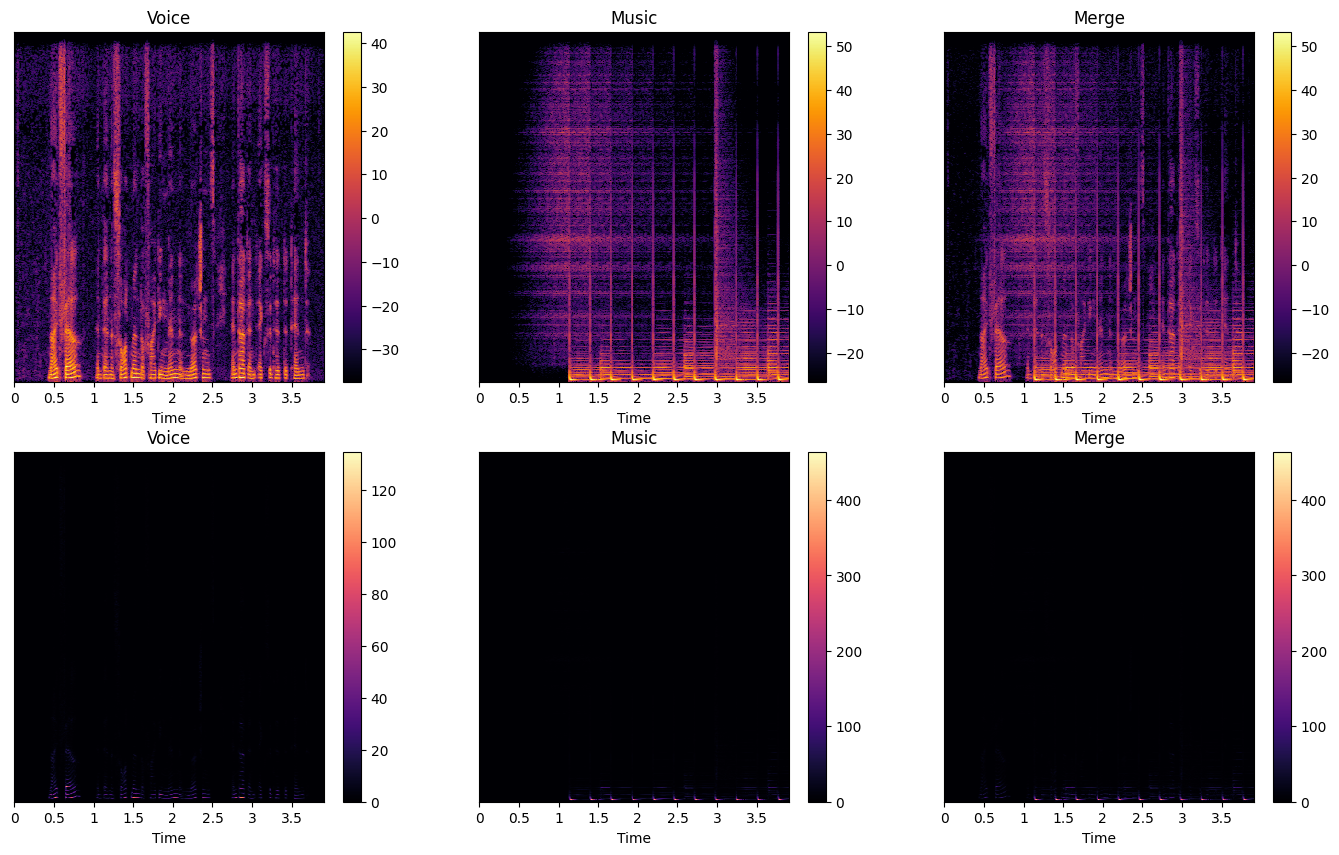

In [13]:
import numpy as np
import matplotlib.pyplot as plt

D_voice = np.abs(librosa.stft(voice_source))
D_music = np.abs(librosa.stft(music_source))
D_merge = np.abs(librosa.stft(merge_source))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17,10))

for ax, D, title in zip(axes[0], [D_voice, D_music, D_merge], ["Voice", "Music", "Merge"]) : 
    S_db = librosa.amplitude_to_db(D)
    cb = librosa.display.specshow(S_db, x_axis="time", sr=sample_rate * 2, ax=ax, cmap="inferno")
    ax.set_title(title)
    plt.colorbar(cb)

for ax, D, title in zip(axes[1], [D_voice, D_music, D_merge], ["Voice", "Music", "Merge"]) : 
    cb = librosa.display.specshow(D, x_axis="time", sr=sample_rate * 2, ax=ax)
    ax.set_title(title)
    plt.colorbar(cb)



In [14]:
print(D_voice.shape, D_music.shape, D_merge.shape)

(1025, 337) (1025, 337) (1025, 337)


In [15]:
from keras.backend import clear_session
from keras import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPool2D, AvgPool2D, Reshape, BatchNormalization, Flatten, Dropout, Conv1D

# class custome_model(Model) : 
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#     pass

clear_session()
model = Sequential(name="test_layer")
model.add(Conv2D(filters=240, kernel_size=(5, 5), input_shape=(1025, 337, 1), activation="relu", padding="same"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Conv2D(filters=120, kernel_size=(5, 5), activation="relu", padding="same"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=60, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=337, kernel_size=(45, 4), activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Reshape(target_shape=(1025, 337)))

model.compile(optimizer="adam", loss="mse", metrics=["mse"])

print(model.summary())

Model: "test_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1025, 337, 240)    6240      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 341, 112, 240)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 341, 112, 120)     720120    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 170, 56, 120)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 170, 56, 120)     480       
 ormalization)                                                   
                                                        

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score

early_stop = EarlyStopping(monitor="loss", patience=200, verbose=False, restore_best_weights=True)
check_point = ModelCheckpoint(filepath="./Model/checkpoints/", monitor="loss", verbose=False, save_best_only=True, save_weights_only=True)
callbacks = [early_stop, check_point]

history = model.fit(D_merge.reshape((1, 1025, 337)), D_voice.reshape(1, 1025, 337), batch_size=3, epochs=200, verbose=2, callbacks=callbacks)
model.save(filepath="./Model/checkpoints/checkpoint.h5")

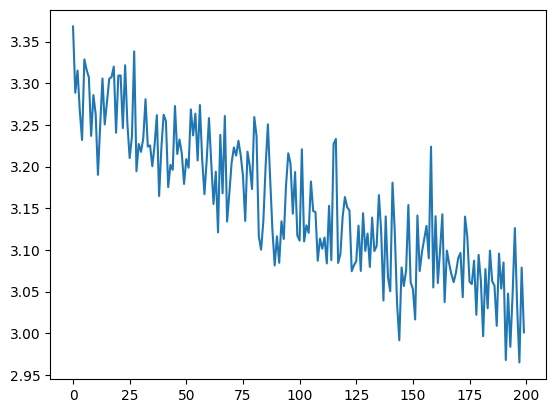

In [21]:
import matplotlib.pyplot as plt

epoch = history.epoch
loss = history.history["loss"]
mse = history.history["mse"]

plt.plot(epoch, loss)
plt.show()

In [22]:
pred = model.predict(D_merge.reshape((1, 1025, 337)), batch_size=1)
pred = pred.reshape((1025, 337))

1/1 [==============================] - 0s 464ms/step


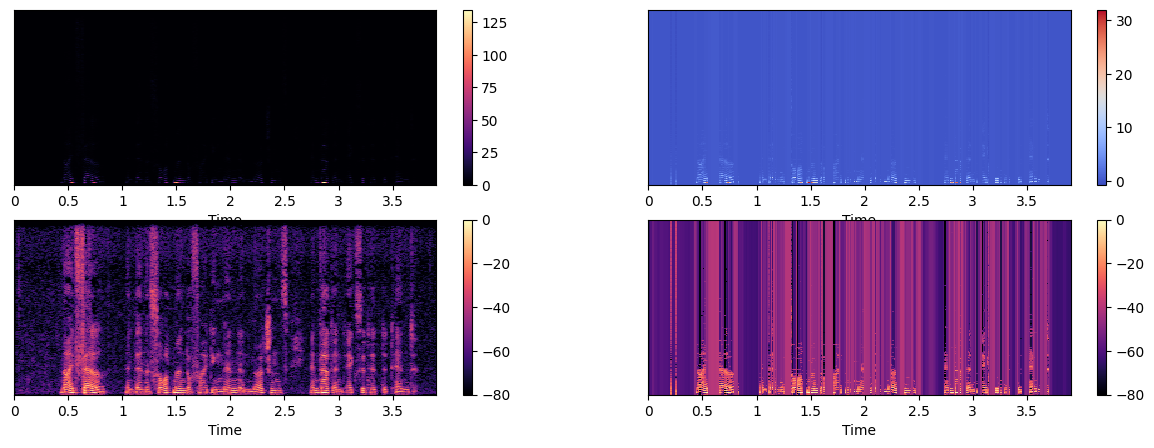

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

for ax, data in zip(axes[0], [D_voice, pred]) : 
    cb = librosa.display.specshow(data, x_axis="time", sr=sample_rate * 2, ax=ax)
    plt.colorbar(cb)

for ax, data in zip(axes[1], [D_voice, pred]) : 
    D_db = librosa.amplitude_to_db(data, ref=np.max)
    cb = librosa.display.specshow(D_db, x_axis="time", sr=sample_rate * 2, ax=ax)
    plt.colorbar(cb)

plt.show()

In [20]:
voice_inverse = librosa.istft(D_voice)
pred_inverse = librosa.istft(pred)

display(Audio(voice_inverse, rate=sample_rate))
display(Audio(pred_inverse, rate=sample_rate))